<h1 align="center">Music Recommender System - Notebook</h1>

<h5 align="center"> Computational Tools for Data Science (02807)</h5>

<h5 align="center">Students: Adrian Valentin (s201390), Christoffer Wejendorp (s204090), Jákup Viljam Dam (s185095) & Jasmin Thari (s204155) </h5>


### Structure of this Notebook

This notebook is organized into seven distinct sections, each designed to guide you through the various stages of the project, from initial setup to in-depth analysis and modeling:

1. **[Introduction](#1)**: Provides an overview of the project and outlines the stages of this notebook.

2. **[Data Preparation](#2)**: Focuses on collecting and structuring the data files into a representative dataset for analysis.

3. **[Pre-processing & Feature Engineering](#3)**: Details the steps taken to clean and prepare the data for analysis, along with feature engineering processes to enhance the dataset.

4. **[Clustering](#4)**: Covers the use of clustering methods for music recommendation. Three approaches are demonstrated: K-means, K-means with PCA, and K-means with Autoencoders. The best-performing clustering model will then be used to recommend songs to users.

5. **[Collaborative Filtering](#5)**: Explores user-based collaborative filtering, which identifies similar users based on their preferences. This method leverages the idea that similar users are likely to have similar music tastes.

6. **[Apriori Algorithm](#6)**: Explores the use of the Apriori algorithm to discover association rules between songs, helping identify songs that are frequently listened to together.

7. **[Ensemble-Based Music Recommendation System](#7)**: Combines the strengths of the three recommendation methods—clustering, collaborative filtering, and the Apriori algorithm—into an ensemble approach for a more accurate and diverse music recommendation system.

---

### Table of Contents
1. **[Introduction](#1)**
2. **[Data Preparation](#2)**
3. **[Pre-processing & Feature Engineering](#3)**
4. **[Clustering](#4)**
5. **[Collaborative Filtering](#5)**
6. **[Apriori Algorithm](#6)**
7. **[Ensemble-Based Music Recommendation System](#7)**



__________

<a id="1"></a>
## Section 1: Introduction

__________

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import time
import json
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from visualization_functions import *

__________

<a id="2"></a>
# Section 2: Data Preparation

In this section, we process raw data from the **Million Song Dataset** to construct datasets suitable for our music recommendation system. The raw data includes:

1. **Song Metadata (HDF5 format)**: Contains details such as artist information, song duration, tempo, key, mode and more.
2. **Genre Information (CLS format)**: Categorizes songs into genres.
3. **User Listening Data (TXT format)**: Logs user interactions with songs, including user IDs and song IDs.
4. **Track-Song Mapping (TXT format)**: Provides a mapping between `track_id` and `song_id` to unify data sources.

The **`MakeData` class** orchestrates the preprocessing steps, which include:

- Extracting metadata and analysis data from HDF5 files.
- Creating a mapping between songs and tracks.
- Merging metadata, analysis, and genre information into a unified dataset.
- Filtering songs played by users for targeted recommendations.

The processed datasets are saved in the `processed` folder within the `data` directory and include:

1. **`all_songs.csv`**: A comprehensive dataset with song metadata and features.
2. **`played_songs.csv`**: A filtered dataset containing only songs that have been played by users. This data is used in our recommendation system.

The raw files are assumed to be located in a `data/raw` folder, in the root directory.

## 2.1: Make Data

In [ ]:
class MakeData:
    """
    A class to create and pre-process the datasets from HDF5 and other raw data files from Million Song Dataset (MSD).
    """

    def __init__(
        self,
        h5_file_path: str,
        unique_tracks_path: str,
        genre_path: str,
        user_data_path: str,
        output_dir: str = "data",
    ):
        """
        Initializes the DataSetMaker with the necessary file paths.

        Parameters:
            h5_file_path (str): Path to the HDF5 file.
            unique_tracks_path (str): Path to the unique_tracks.txt file.
            genres_paths (list): List of paths to genres files (e.g., ['cd1', 'cd2', 'cd2c']).
            user_data_path (str): Path to the user_data.txt file.
            output_dir (str): Directory where output CSV files will be saved.
        """
        self.h5_file_path = h5_file_path
        self.unique_tracks_path = unique_tracks_path
        self.genre_path = genre_path 
        self.user_data_path = user_data_path
        self.output_dir = output_dir

        # Ensure the output directory exists
        os.makedirs(self.output_dir, exist_ok=True)

        # Initialize dictionaries and DataFrames
        self.dfs = {}
        self.song_to_track_mapping = pd.DataFrame()
        self.merged_df = pd.DataFrame()

    def extract_dfs_from_h5(self):
        """
        Extracts datasets from the HDF5 file and stores them as pandas DataFrames in a dictionary.
        """
        def extract_df_from_h5(file, indent=0, datasets=None):
            if datasets is None:
                datasets = {}
            for key in file:
                item = file[key]
                print("  " * indent + f"- {key}: {type(item)}")

                if isinstance(item, h5py.Group):
                    # Recursively extract from groups
                    extract_df_from_h5(item, indent + 1, datasets)
                elif isinstance(item, h5py.Dataset):
                    # Extract dataset into DataFrame
                    columns = list(item.dtype.names)
                    df = pd.DataFrame(item[:], columns=columns)

                    # Decode byte columns to strings if necessary
                    for col in df.columns:
                        if df[col].dtype == 'O' and isinstance(df[col].iloc[0], bytes):
                            df[col] = df[col].apply(
                                lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
                            )

                    # Store the DataFrame with the dataset's full path as the key
                    datasets[item.name] = df
            return datasets

        with h5py.File(self.h5_file_path, 'r') as h5_file:
            self.dfs = extract_df_from_h5(h5_file)
        print("Extraction from HDF5 completed.")

    def create_song_to_track_mapping(self):
        """
        Creates a mapping between song IDs and track IDs from the unique_tracks.txt file.
        """
        df_unique_tracks = pd.read_csv(
            self.unique_tracks_path,
            sep='<SEP>',
            header=None,
            engine='python',
            names=['track_id', 'song_id', 'artist', 'title']
        )
        self.song_to_track_mapping = df_unique_tracks[['song_id', 'track_id']].drop_duplicates(subset='song_id', keep='first')
        print("Song to track mapping created.")

    def merge_metadata_and_analysis(self):
        """
        Merges metadata and analysis DataFrames based on song_id and track_id.
        Also cleans the merged DataFrame by removing unnecessary columns.
        """
        # Load necessary DataFrames
        metadata_df = self.dfs.get('/metadata/songs')
        analysis_df = self.dfs.get('/analysis/songs')

        if metadata_df is None or analysis_df is None:
            raise ValueError("Required datasets '/metadata/songs' or '/analysis/songs' not found in HDF5 file.")

        # Drop duplicate song_ids
        metadata_df = metadata_df.drop_duplicates(subset='song_id', keep='first')

        # Merge with song_to_track_mapping
        merged_df = metadata_df.merge(self.song_to_track_mapping, on='song_id', how='inner')

        # Merge with analysis_df on track_id
        merged_df = merged_df.merge(analysis_df, on='track_id', how='inner')

        # Remove unnecessary columns
        columns_to_drop = [
            "artist_7digitalid",
            "artist_mbid",
            "artist_playmeid",
            "release_7digitalid",
            "track_7digitalid",
            "audio_md5",
        ]
        merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])

        # Remove columns with only one unique value
        merged_df = merged_df.loc[:, merged_df.nunique() > 1]

        self.merged_df = merged_df
        print("Metadata and analysis DataFrames merged and cleaned.")
    
    def process_genres(self):
        
        """
        Processes genre classification files and merges them into a single DataFrame.
        """        
        df_genre = pd.read_csv(
            self.genre_path,
            sep="\t",
            comment='#',
            header=None,
            names=["trackId", "majority_genre", "minority_genre"],
            engine='python'
        )
        
        # Remove minority_genre column and rename majority_genre to genre
        df_genre = df_genre.drop(columns=['minority_genre'])
        df_genre = df_genre.rename(columns={'majority_genre': 'genre'})
      
        # merge with the merged_df
        self.merged_df = self.merged_df.merge(df_genre, left_on='track_id', right_on='trackId', how='left')
        self.merged_df = self.merged_df.drop(columns=['trackId'])

    def save_merged_df(self):
        """
        Saves the merged DataFrame to a CSV file.
        """
        # Sort columns alphabetically
        self.merged_df = self.merged_df.reindex(sorted(self.merged_df.columns), axis=1)

        # Define the output path
        merged_csv_path = os.path.join(self.output_dir, "all_songs.csv")
        self.merged_df.to_csv(merged_csv_path, index=False)
        print(f"Merged DataFrame saved to {merged_csv_path}")

    def process_played_songs(self):
        """
        Load user data to find and save songs that have been played by users.
        """
        # Load user data
        df_user_data = pd.read_csv(
            self.user_data_path,
            sep='\t',
            header=None,
            names=['user_id', 'song_id', 'play_count']
        )
        print("User data loaded.")

        # Find unique song_ids that have been played
        unique_song_ids = df_user_data['song_id'].unique()
        print(f"Found {len(unique_song_ids)} unique song IDs in user data.")

        # Load all songs DataFrame
        all_songs_csv_path = os.path.join(self.output_dir, "all_songs.csv")
        df_all_songs = pd.read_csv(all_songs_csv_path)
        print("All songs DataFrame loaded.")

        # Merge to find played songs
        df_played_songs = df_all_songs.merge(
            pd.DataFrame(unique_song_ids, columns=['song_id']),
            on='song_id',
            how='inner'
        )
        print(f"Found {len(df_played_songs)} songs that have been played by users.")

        # Save played songs to CSV
        played_songs_csv_path = os.path.join(self.output_dir, "played_songs.csv")
        df_played_songs.to_csv(played_songs_csv_path, index=False)
        print(f"Played songs DataFrame saved to {played_songs_csv_path}")

    def preprocess_data(self):
        """
        Executes all processing steps in sequence.
        """
        print("Starting data extraction from HDF5...")
        self.extract_dfs_from_h5()

        print("Creating song to track mapping...")
        self.create_song_to_track_mapping()

        print("Merging metadata and analysis DataFrames...")
        self.merge_metadata_and_analysis()

        print("Processing genres...")
        self.process_genres()
        
        print("Saving merged DataFrame to CSV...")
        self.save_merged_df()

        print("Processing user data...")
        self.process_played_songs()

        print("All processing steps completed successfully.")

In [ ]:
def get_data():
    # Define file paths
    h5_file = 'data/raw/msd_summary_file.h5'
    unique_tracks = 'data/raw/unique_tracks.txt'
    genre_path = 'data/raw/msd_tagtraum_cd2c.cls'
    user_data = 'data/raw/user_data.txt'
    output_directory = 'data/processed'

    # Initialize the DataSetMaker
    dataset_maker = MakeData(
        h5_file_path=h5_file,
        unique_tracks_path=unique_tracks,
        genre_path=genre_path,
        user_data_path=user_data,
        output_dir=output_directory
    )

    # Run all processing steps
    dataset_maker.preprocess_data()

In [17]:
# Run this line to get the data
get_data()

Starting data extraction from HDF5...
- analysis: <class 'h5py._hl.group.Group'>
  - songs: <class 'h5py._hl.dataset.Dataset'>
- metadata: <class 'h5py._hl.group.Group'>
  - songs: <class 'h5py._hl.dataset.Dataset'>
- musicbrainz: <class 'h5py._hl.group.Group'>
  - songs: <class 'h5py._hl.dataset.Dataset'>
Extraction from HDF5 completed.
Creating song to track mapping...
Song to track mapping created.
Merging metadata and analysis DataFrames...
Metadata and analysis DataFrames merged and cleaned.
Processing genres...
Saving merged DataFrame to CSV...
Merged DataFrame saved to data/all_songs.csv
Processing user data...
User data loaded.
Found 384546 unique song IDs in user data.
All songs DataFrame loaded.
Found 384546 songs that have been played by users.
Played songs DataFrame saved to data/played_songs.csv
All processing steps completed successfully.


## 2.2: Load Data

In [18]:
class LoadData:
    """
    A class to load and manage datasets related to songs and user interactions.
    """

    def load_csv_file(self, data_path: str):
        """
        Loads the data_path file .csv file into a pandas DataFrame.
        """
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"{data_path} does not exist.")
        df = pd.read_csv(data_path)
        return df
    
    def load_txt_file(self, data_path: str):
        """
        Loads the data_path file .csv file into a pandas DataFrame.
        """
        df = pd.read_csv(
            data_path,
            sep='\t',
            header=None,
            names=['user_id', 'song_id', 'play_count'], 
            engine='python'
        )
        return df

data_loader = LoadData()

In [19]:
df_played_songs = data_loader.load_csv_file(data_path='data/processed/played_songs.csv')
df_user = data_loader.load_txt_file(data_path='data/raw/user_data.txt')

In [20]:
print("Played songs shape:", df_played_songs.shape)
print("User data shape:", df_user.shape)

Played songs shape: (384546, 24)
User data shape: (48373586, 3)


In [21]:
df_played_songs.head(3)

,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,end_of_fade_in,genre,...,mode_confidence,release,song_hotttnesss,song_id,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,track_id
0,0.649822,0.394032,ARYZTJS1187B98C555,NaN,NaN,NaN,Faster Pussy cat,252.05506,2.049,NaN,...,0.688,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,236.635,87.002,4,0.940,Silent Night,TRMMMYQ128F932D901
1,0.448501,0.372349,ARNWYLR1187B9B2F9C,NaN,NaN,NaN,Yerba Brava,145.05751,0.000,NaN,...,0.451,De Culo,NaN,SOBNYVR12A8C13558C,138.687,87.433,4,0.000,Si Vos Querés,TRMMMCH128F425532C
2,0.555014,0.352949,AR59BSJ1187FB4474F,NaN,NaN,NaN,3 Gars Su'l Sofa,68.96281,0.363,NaN,...,0.590,Des cobras des tarentules,NaN,SOYGNWH12AB018191E,68.963,62.294,4,0.425,L'antarctique,TRMMMNS128F93548E1


In [22]:
df_user.head(3)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2


<a id="3"></a>
# 3. Pre-processing & Feature Engineering

In this section, we preprocess the dataset and engineer features to optimize it for clustering and recommendation tasks. The key steps include:

- **Handling Missing Values**: Dropping rows with missing values (`NaN`) for columns critical to clustering.
- **One-Hot Encoding**: Encoding the `genre` column into binary features for each genre.
- **Frequency Encoding**: Encoding categorical columns, such as `artist_name` and `release`, based on their frequency of occurrence in the dataset.
- **Hashing Encoding**: Encoding `artist_name` using a hashing technique for efficient representation.
- **GeoPy for Geolocation Data**: Filling in missing longitude and latitude values for artist location using GeoPy to retrieve location data based on available information.

After preprocessing, the cleaned and feature-engineered data is saved as a new CSV file for subsequent analysis.

Additionally, we preprocess the user data by filtering for users who have listened to at **least 20 songs**. This ensures sufficient data is available for making reliable recommendations and for masking data during prediction tasks.

## 3.1: Data Cleaning

In [7]:
def drop_missing_values(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Drops rows with missing values in specified columns.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.
        columns (list): List of column names to check for missing values.

    Returns:
        pd.DataFrame: Cleaned dataframe with missing values dropped.
    """
    cleaned_df = df.dropna(subset=columns).reset_index(drop=True)
    return cleaned_df

In [23]:
# Drop missing values
required_columns = ['genre', 'song_hotttnesss', 'artist_familiarity', 'title', 'artist_location']
df_played_songs = drop_missing_values(df_played_songs, required_columns)

## 3.2: Feature Engineering

In [ ]:
class FeatureEngineer:
    """
    A class for engineering features such as artist frequency and hashed artist names.
    """
    
    def one_hot_encode(self, df: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        One-hot encodes a column in the dataframe.

        Parameters:
            df (pd.DataFrame): The dataframe containing the column to encode.
            column (str): The column name to one-hot encode.

        Returns:
            pd.DataFrame: The dataframe with the one-hot encoded column.
        """
        one_hot_encoded = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, one_hot_encoded], axis=1)
        return df

    def calculate_frequency(self, df: pd.DataFrame, column: str) -> pd.Series:
        """
        Calculates the frequency of each category in the column in the dataset.

        Parameters:
            df (pd.DataFrame): The dataframe containing artist data.
            column (str): The column name to calculate frequency for.

        Returns:
            pd.Series: A series mapping the category to their frequencies.
        """
        freq = df[column].value_counts()
        return freq

    def hash_artist_features(self, df: pd.DataFrame, n_features, artist_column: str = 'artist_name') -> pd.DataFrame:
        """
        Applies feature hashing to the artist names.

        Parameters:
            df (pd.DataFrame): The dataframe containing artist data.
            artist_column (str): The column name for artist names.

        Returns:
            pd.DataFrame: A dataframe with hashed artist features.
        """
        hasher = FeatureHasher(n_features=n_features, input_type='dict', alternate_sign=False)
        feature_dicts = [{'artist_' + name: 1} for name in df[artist_column]]
        hashed_features = hasher.transform(feature_dicts)
        hashed_features_dense = hashed_features.toarray()
        hashed_df = pd.DataFrame(hashed_features_dense, 
                                  columns=[f'artist_hash_{i}' for i in range(n_features)])
        return hashed_df

In [ ]:
feature_engineer = FeatureEngineer()

# One-hot encode genres
df_played_songs = feature_engineer.one_hot_encode(df_played_songs, 'genre')

# Calculate artist frequency
artist_freq = feature_engineer.calculate_frequency(df_played_songs, 'artist_name')

# Hash artist features
hashed_df = feature_engineer.hash_artist_features(df_played_songs, n_features=50)

# Calculate release frequency
release_freq = feature_engineer.calculate_frequency(df_played_songs, 'release')

# Concatenate hashed features, artist_freq and release_freq with the songs dataframe
df_processed = pd.concat([df_played_songs, hashed_df], axis=1)
df_processed['artist_freq'] = df_processed['artist_name'].map(artist_freq)
df_processed['release_freq'] = df_processed['release'].map(release_freq)

In [ ]:
class GeocoderService:
    """
    A class to handle geocoding of artist locations to obtain latitude and longitude.
    """

    def __init__(self, user_agent: str = "music_recommender"):
        """
        Initializes the GeocoderService with a specified user agent.

        Parameters:
            user_agent (str): User agent string for the Nominatim geocoder.
        """
        self.geolocator = Nominatim(user_agent=user_agent)

    def get_lat_lon(self, location: str) -> list:
        """
        Retrieves the latitude and longitude for a given location.

        Parameters:
            location (str): The location string to geocode.

        Returns:
            list: A list containing latitude and longitude. [latitude, longitude]
        """
        try:
            loc = self.geolocator.geocode(location)
            if loc:
                return [loc.latitude, loc.longitude]
            else:
                return [np.nan, np.nan]
        except Exception as e:
            print(f"Error geocoding '{location}': {e}")
            return [np.nan, np.nan]
        finally:
            time.sleep(1)  

In [ ]:
geocoder = GeocoderService()

# Handle missing latitude and longitude of artist bu Geocode using locations
missing_condition = (df_processed['artist_latitude'].isna() | df_processed['artist_longitude'].isna())
missing_coordinates = df_processed.loc[missing_condition, 'artist_location'].unique()

location_coords = {}
for location in missing_coordinates:
    lat, lon = geocoder.get_lat_lon(location)
    if not (np.isnan(lat) or np.isnan(lon)):
        location_coords[location] = (lon, lat)  
    else:
        location_coords[location] = (np.nan, np.nan)  # Handle failed geocoding

def get_lat(location):
    return location_coords.get(location, (np.nan, np.nan))[1]

def get_lon(location):
    return location_coords.get(location, (np.nan, np.nan))[0]

# Apply the mapping to fill in missing latitude and longitude
df_processed.loc[missing_condition, 'artist_latitude'] = df_processed.loc[missing_condition, 'artist_location'].apply(get_lat)
df_processed.loc[missing_condition, 'artist_longitude'] = df_processed.loc[missing_condition, 'artist_location'].apply(get_lon)

# Drop rows with missing latitude and longitude which could not be filled
df_processed.dropna(subset=['artist_latitude', 'artist_longitude'], inplace=True)

In [24]:
df_played_songs_preprocessed = data_loader.load_csv_file(data_path='data/processed/played_songs_cleaned.csv')

In [25]:
print("Preprocessed played songs shape:", df_played_songs_preprocessed.shape)

Preprocessed played songs shape: (64539, 91)


In [27]:
df_played_songs_preprocessed.head(2)

,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,end_of_fade_in,genre,...,artist_hash_42,artist_hash_43,artist_hash_44,artist_hash_45,artist_hash_46,artist_hash_47,artist_hash_48,artist_hash_49,artist_freq,release_freq
0,0.529819,0.410229,ARSB5591187B99A848,57.426350,"Vetlanda, Sweden",15.085180,Lena Philipsson,262.26893,0.194,Pop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
1,0.738996,0.563367,ARDT9VH1187B999C0B,33.687439,South Carolina,-80.436374,Emery,217.57342,0.514,Rock,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,4


## 3.3: Preprocess user data

In [ ]:
def filter_users_with_min_songs(df_user: pd.DataFrame, df_songs_subs: pd.DataFrame, min_songs: int) -> pd.DataFrame:
    """
    Filters users who have subscribed to at least a specified number of songs.

    Parameters:
        df_user (pd.DataFrame): User dataframe.
        df_songs_subs (pd.DataFrame): Subscribed songs dataframe.
        min_songs (int): Minimum number of songs a user must have subscribed to.

    Returns:
        pd.DataFrame: Filtered dataframe with users meeting the criteria.
    """
    merged_df = pd.merge(df_songs_subs[['song_id']], df_user, on='song_id', how='left')
    user_subs_filtered = merged_df[merged_df.groupby('user_id')['user_id'].transform('count') > min_songs]
    return user_subs_filtered

In [ ]:
# Filter users with at least 20 song subscriptions
df_user_preprocessed = filter_users_with_min_songs(df_user, df_played_songs_preprocessed, min_songs=20)
df_user_preprocessed.to_csv('data/processed/user_data_cleaned.csv', index=False)

In [28]:
df_user_preprocessed = data_loader.load_csv_file(data_path='data/processed/user_data_cleaned.csv')

In [29]:
print("Preprocessed user data shape:", df_user_preprocessed.shape)

Preprocessed user data shape: (7749050, 3)


## 3.4: Split data # vend tilbage til denne når vi er kommet frem til hvilket split vi vil lave

In [30]:
def split_listened_and_masked(dataframe):
    """
    Splits the input dataframe into two separate dataframes: one containing the first 10 songs 
    (masked) for each user and the other containing the remaining songs (listened).

    Args:
        dataframe (pd.DataFrame): The input dataframe containing user listening data. 
                                  It must have a 'user_id' column to group by users.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
            - listened (pd.DataFrame): DataFrame containing the remaining songs after the first 10 for each user.
            - masked (pd.DataFrame): DataFrame containing the first 10 songs for each user.
    """
    listened = []
    masked = []
    for user, group in dataframe.groupby('user_id'):
        group = group.sample(frac=1, random_state=42)  # Shuffle group
        masked.append(group.iloc[:10])  # First 10 songs as masked
        listened.append(group.iloc[10:])  # Remaining songs as listened

    return pd.concat(listened), pd.concat(masked)

def stratified_split(dataframe, split_ratio=0.8):
    """
    Splits a dataframe into two parts in a stratified manner based on user_id.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing user interaction data.
    split_ratio (float): The ratio to split the data into listened and masked parts. Default is 0.8.

    Returns:
    tuple: Two dataframes, the first containing the listened part and the second containing the masked part.
    """
    listened = []
    masked = []
    for user, group in dataframe.groupby('user_id'):
        group = group.sample(frac=1, random_state=42)  # Shuffle group
        split_index = int(len(group) * split_ratio)  # Calculate split point
        listened.append(group.iloc[:split_index])  # First part as listened
        masked.append(group.iloc[split_index:])  # Remaining part as masked

    return pd.concat(listened), pd.concat(masked)

In [ ]:
unique_users = df_user_preprocessed['user_id'].unique()

# Split users into training and testing sets using a 85-15 split
train_users, test_users = train_test_split(unique_users, test_size=0.15, random_state=42)

df_interactions_test_users = df_user_preprocessed[df_user_preprocessed['user_id'].isin(test_users)]
listened_songs, masked_songs = split_listened_and_masked(df_interactions_test_users)

listened_songs, masked_songs = stratified_split(df_interactions_test_users, split_ratio=0.8)

In [32]:
train_users = data_loader.load_csv_file(data_path='data/processed/train_users.csv')
test_users = data_loader.load_csv_file(data_path='data/processed/test_users.csv')

In [33]:
print("Train users shape:", train_users.shape)
print("Test users shape:", test_users.shape)

Train users shape: (156236, 1)
Test users shape: (27572, 1)


# 4. Clustering

In this section, we’ll cluster unique songs using their metadata to group similar songs together based on their features. This clustering will help us recommend songs to users by identifying the clusters that the user belongs most to based on the music they’ve already listened to.

To achieve this, we will explore two distinct clustering methodologies: 

1. **K-Means Clustering with PCA**: Principal Component Analysis (PCA) will be employed to reduce the dimensionality of the song features, capturing the most significant variations in the data while retaining the essential information for clustering. 

2. **K-Means Clustering with Autoencoder**: An autoencoder, a neural network designed for unsupervised feature extraction, will be used to compress the song metadata into a lower-dimensional latent space. The resulting latent representations will then serve as inputs for K-means clustering, leveraging the power of deep learning to extract complex patterns and relationships between songs.

Based on the best obtained clustering, we will use the identified clusters to recommend songs to users based on the songs they have listened to.

## 4.0: Define Functions

In [3]:
class StandardizeFeatures:
    """
    A class to prepare the processed data for modeling by splitting into training and testing sets and standardizing features.
    """
    def __init__(self, random_state: int = 42):
        """
        Initializes the DataModelPreparer with target column and split parameters.

        Parameters:
            random_state (int): Controls the shuffling applied to the data before applying the split.
        """
        self.random_state = random_state
        self.scaler = StandardScaler()

    def fit_transform_scaler(self, X_train: pd.DataFrame) -> pd.DataFrame:
        """
        Fits the scaler on the training data and transforms it.

        Parameters:
            X_train (pd.DataFrame): Training feature data.

        Returns:
            pd.DataFrame: Scaled training feature data.
        """
        scaled_train = self.scaler.fit_transform(X_train)
        scaled_train_df = pd.DataFrame(scaled_train, columns=X_train.columns, index=X_train.index)
        return scaled_train, scaled_train_df

    def transform_scaler(self, X_test: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the test data using the already fitted scaler.

        Parameters:
            X_test (pd.DataFrame): Testing feature data.

        Returns:
            pd.DataFrame: Scaled testing feature data.
        """
        scaled_test = self.scaler.transform(X_test)
        scaled_test_df = pd.DataFrame(scaled_test, columns=X_test.columns, index=X_test.index)
        return scaled_test, scaled_test_df

In [52]:
def determine_number_of_clusters_for_KMeans(data, max_clusters, random_state=42):
    """
    Evaluates KMeans clustering using WCSS, Silhouette Score, and Davies-Bouldin Index for different number of clusters to determine the optimal number.

    Parameters:
        data (pd.DataFrame or np.ndarray): The input data for clustering.
        max_clusters (int): Maximum number of clusters to evaluate.
        random_state (int): Random state for reproducibility.

    Returns:
        dict: A dictionary containing:
              - 'wcss': Within-cluster sum of squares for each cluster size.
              - 'silhouette_scores': Silhouette scores for each cluster size (2 to max_clusters).
              - 'davies_bouldin_indices': Davies-Bouldin indices for each cluster size (2 to max_clusters).
    """
    wcss = []
    silhouette_scores = []
    davies_bouldin_indices = []

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=random_state)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

        if i > 1:  # Silhouette and Davies-Bouldin require at least 2 clusters
            cluster_labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(data, cluster_labels))
            davies_bouldin_indices.append(davies_bouldin_score(data, cluster_labels))

    return {
        "wcss": wcss,
        "silhouette_scores": silhouette_scores,
        "davies_bouldin_indices": davies_bouldin_indices
    }

In [6]:
# Initialize the StandardizeFeatures class
feature_scaler = StandardizeFeatures(random_state=42)

In [8]:
# Load data used for this section 
df_songs_cleaned = data_loader.load_csv_file(data_path='data/processed/played_songs_cleaned.csv')

In [9]:
# Select columns for clustering
cols_clustering = ['artist_familiarity', 'artist_hotttnesss','artist_latitude','artist_longitude','artist_freq',
                    'duration', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 'song_hotttnesss', 'end_of_fade_in','start_of_fade_out','release_freq',
                    'genre_Blues','genre_Country', 'genre_Electronic', 'genre_Folk', 'genre_Jazz','genre_Latin', 'genre_Metal', 'genre_New Age', 
                    'genre_Pop','genre_Punk', 'genre_Rap', 'genre_Reggae', 'genre_RnB', 'genre_Rock','genre_World']
df_clustering = df_songs_cleaned[cols_clustering]

## 4.1: K-Means Clustering

In [78]:
clustering_scaled , df_clustering_scaled = feature_scaler.fit_transform_scaler(df_clustering)

In [80]:
max_clusters = 20
scores_kmeans_dict = determine_number_of_clusters_for_KMeans(clustering_scaled, max_clusters=max_clusters) 

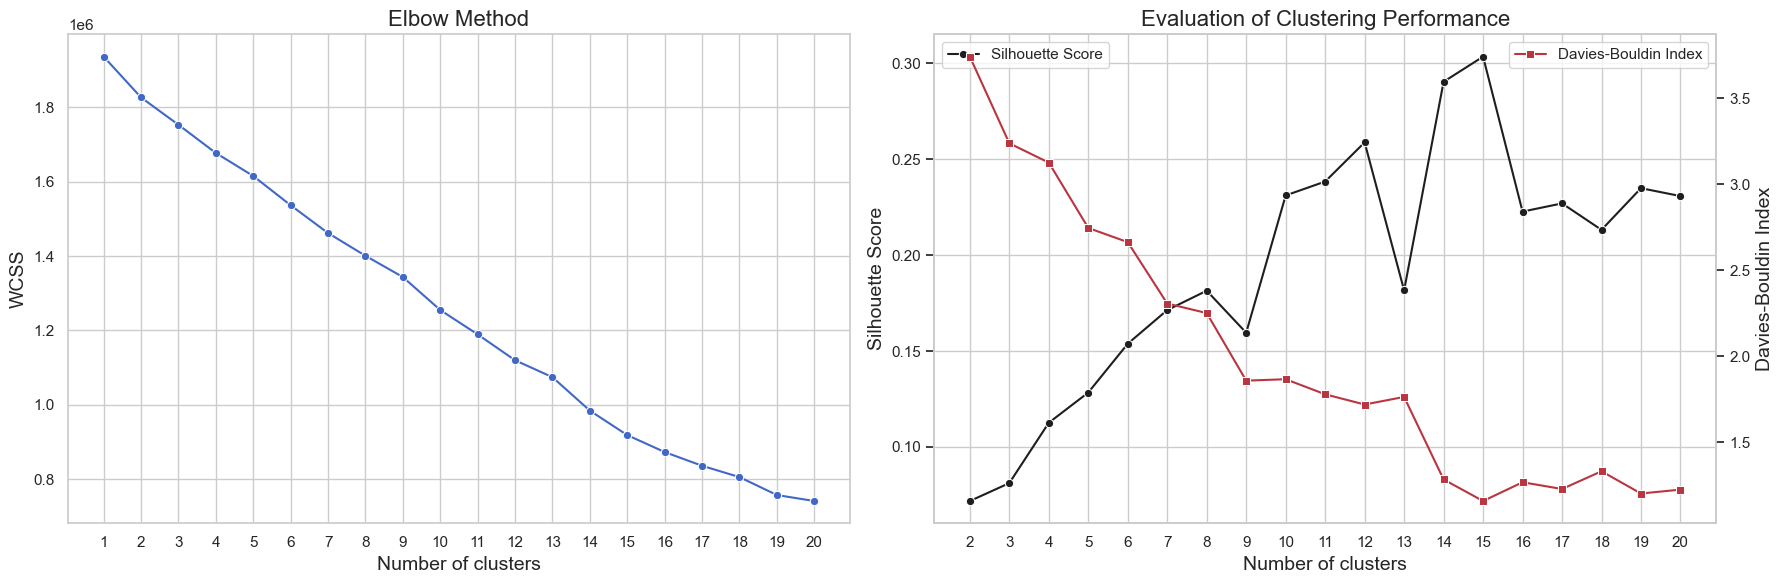

In [81]:
plot_cluster_evaluation(scores_kmeans_dict, max_clusters)

In [83]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clustering['cluster'] = kmeans.fit_predict(df_clustering) + 1

/Users/jasmink.j.thari/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


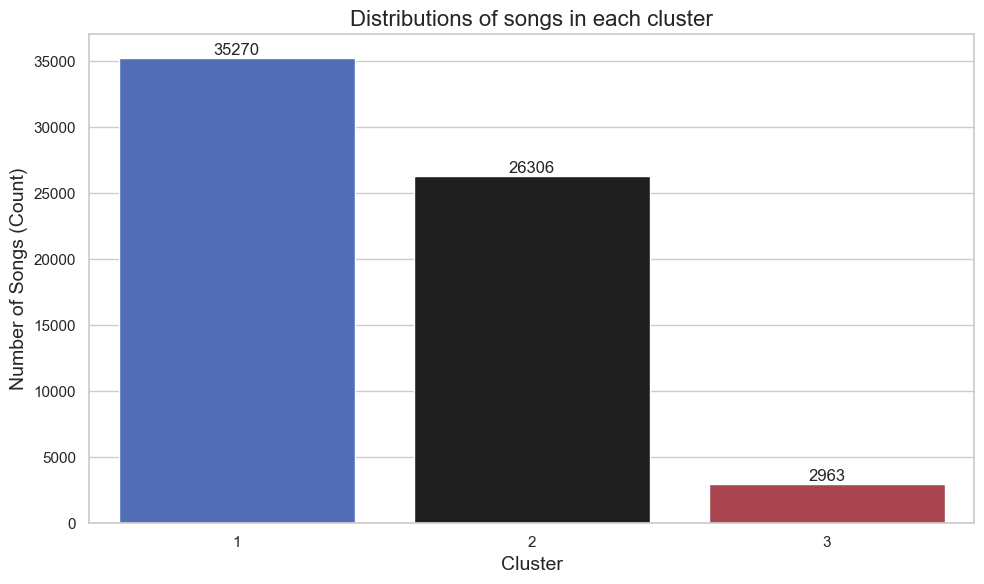

In [84]:
plot_cluster_distribution(df_clustering)

In [90]:
# Evaluate performance
silhouette_score_pca = silhouette_score(df_clustering.drop(columns=['cluster']), df_clustering['cluster'])
davies_bouldin_pca = davies_bouldin_score(df_clustering.drop(columns=['cluster']), df_clustering['cluster'])

print(f"Silhouette Score: {silhouette_score_pca:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_pca:.4f}")

Silhouette Score: 0.3254
Davies-Bouldin Index: 1.0003


- We see that the K-Means clustering on the raw data does not perform well. This is can be either due to the high dimensionality of the data, which makes it difficult for K-Means to identify meaningful clusters. To address this, we will apply PCA to reduce the dimensionality of the data before clustering.

## 4.2: K-Means Clustering with PCA

In [ ]:
def run_pca(data: pd.DataFrame, n_components: int):
    """
    Trains a Principal Component Analysis (PCA) model on the given data and transforms the data into the specified number of principal components.

    Args:
        data (DataFrame): 
            The input data to be used for PCA. 
        n_components (int): 
            The number of principal components to retain during the transformation.

    Returns:
        tuple: A tuple containing:
            - PCA object: The trained PCA model containing information such as explained variance and components.
            - array-like: The transformed data in the reduced-dimensionality space.
    """
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(data)
    pca_transformed = pca.fit_transform(data)
    return pca, pca_transformed

In [10]:
# Standardize the features for clustering
clustering_scaled , df_clustering_scaled = feature_scaler.fit_transform_scaler(df_clustering)

In [11]:
# Run PCA to reduce the dimensionality of the data
pca, pca_transformed = run_pca(clustering_scaled, n_components=df_clustering_scaled.shape[1])

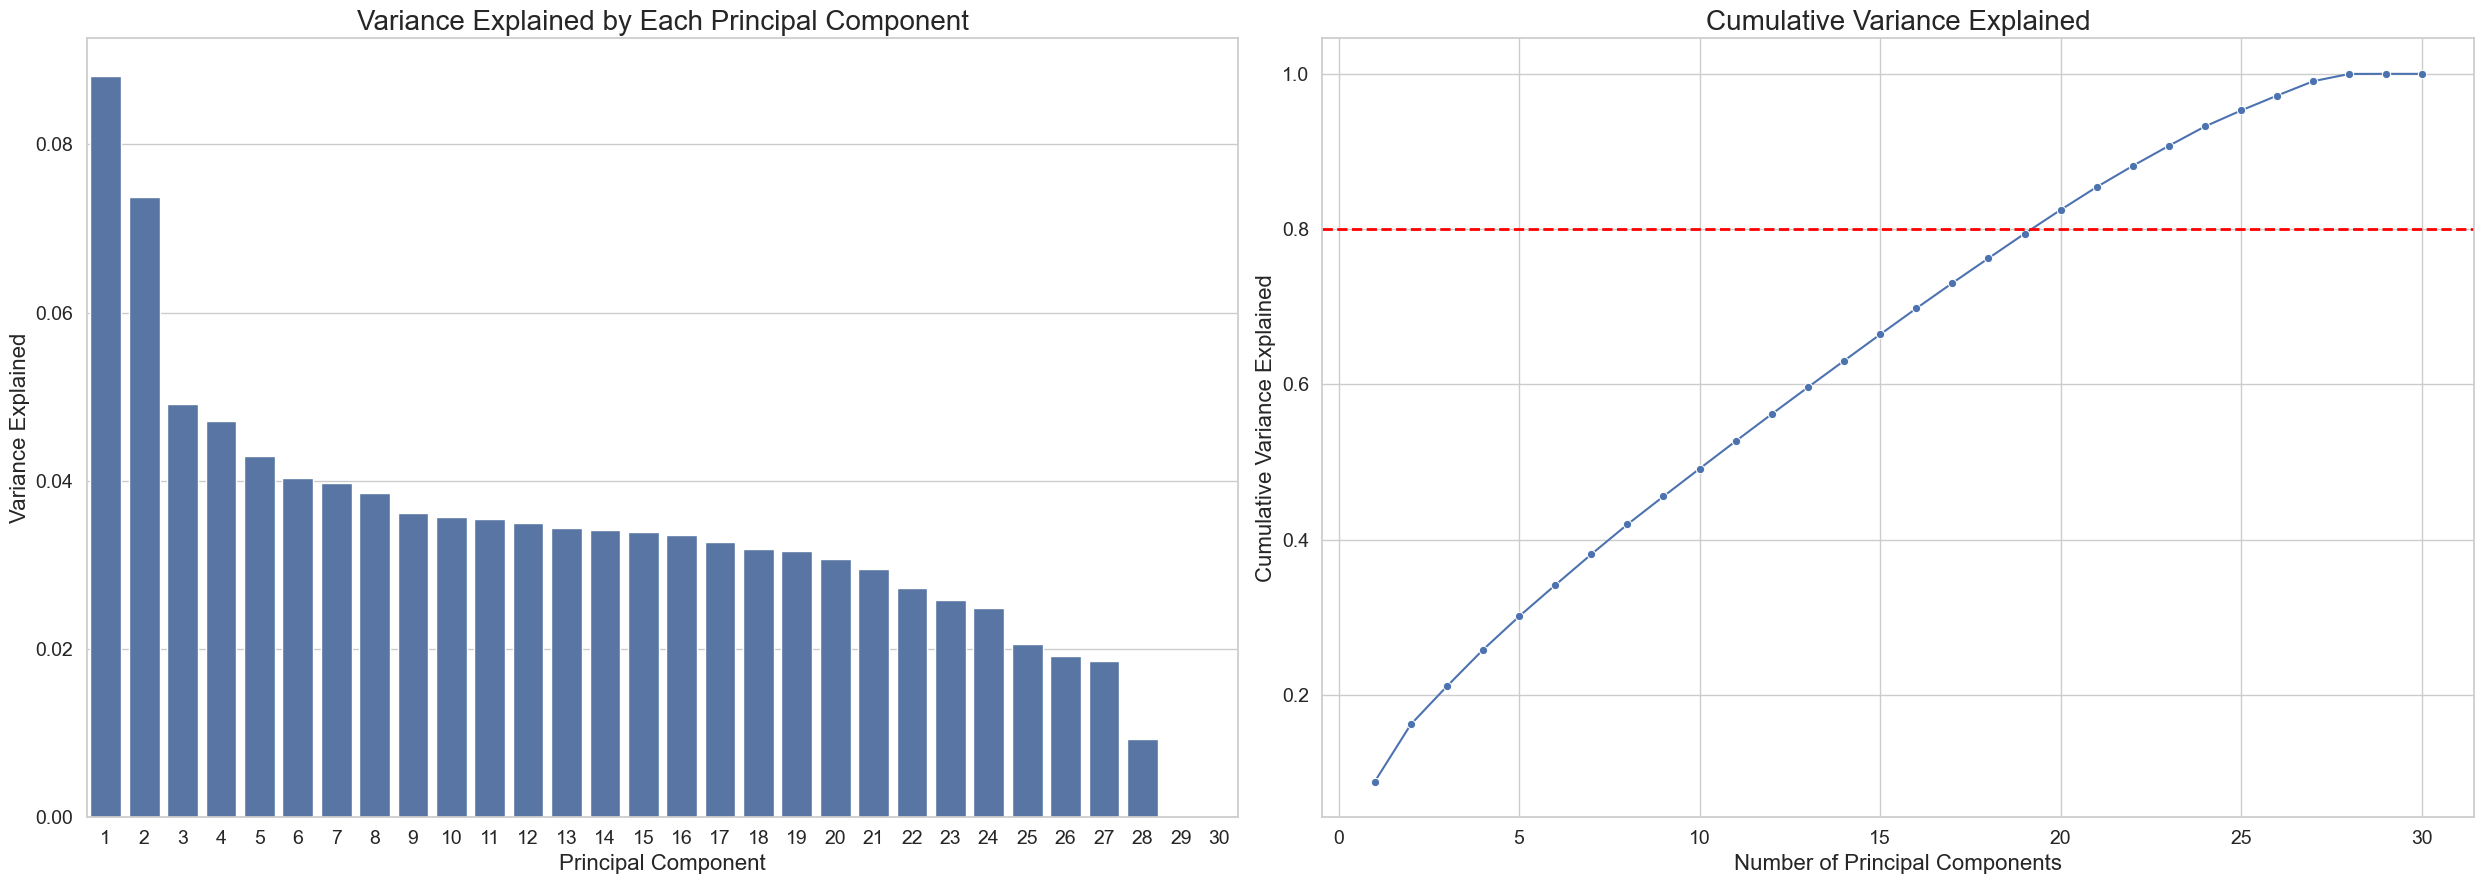

In [49]:
# Determine the optimal number of components for PCA
plot_pca_variance(pca)

- We need 19 PCs to explain 80% of the variance in the data.

In [50]:
num_pca = 19
pca, pca_transformed = run_pca(clustering_scaled, n_components=num_pca)
df_pca = pd.DataFrame(pca_transformed[:, :num_pca], columns=[f'PC{i+1}' for i in range(num_pca)])

In [ ]:
max_clusters = 20
scores_pca_dict = determine_number_of_clusters_for_KMeans(df_pca, max_clusters=max_clusters) 

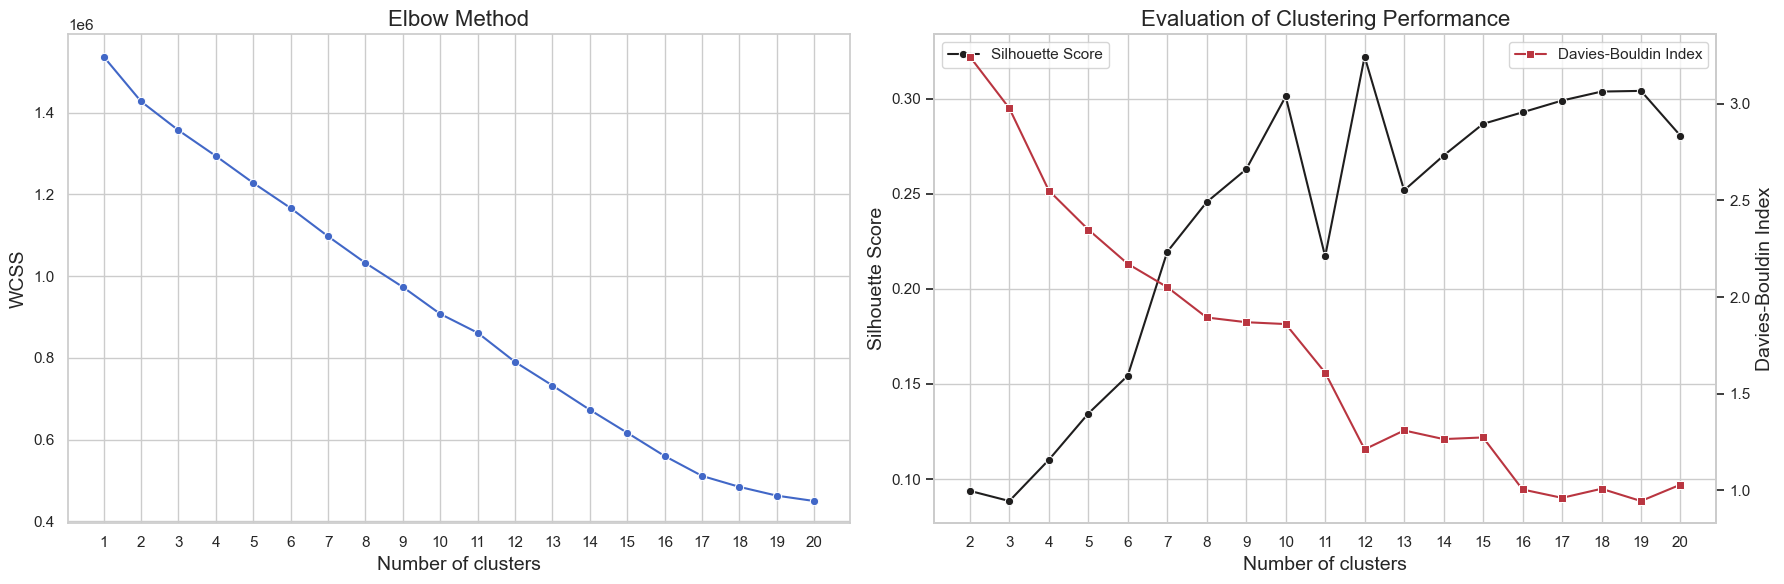

In [70]:
plot_cluster_evaluation(scores_pca_dict, max_clusters)

- Optimal number of clusters are determined using the Silhouette Score and Davies-Bouldin score, as the Elbow Method is not showing any clear elbow.
- The optimal number of clusters is then determined to be 17.

In [64]:
optimal_k = 17
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca) + 1

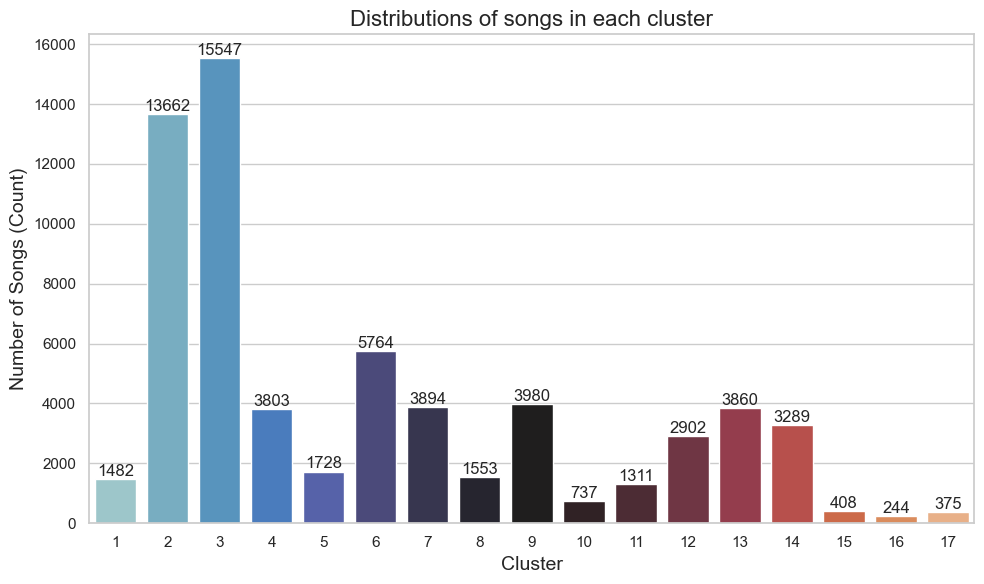

In [68]:
plot_cluster_distribution(df_pca)

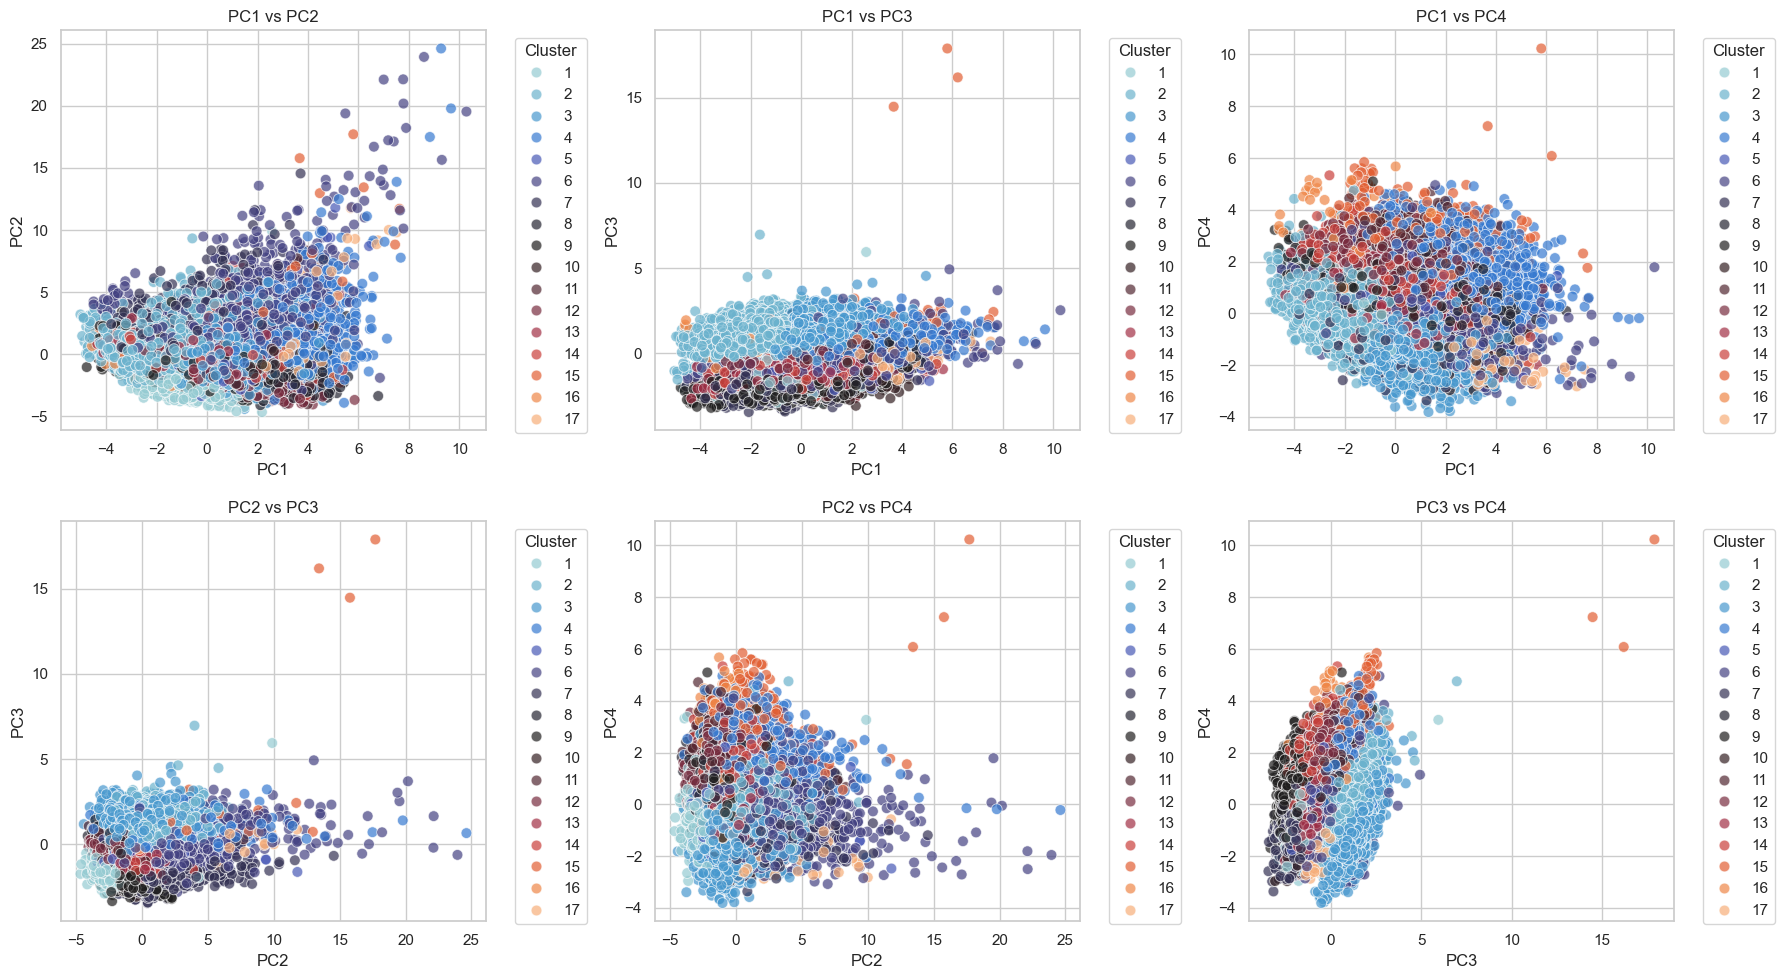

In [76]:
plot_pca_clustering(df_pca, optimal_k)

In [91]:
# Evaluate performance
silhouette_score_pca = silhouette_score(df_pca.drop(columns=['cluster']), df_pca['cluster'])
davies_bouldin_pca = davies_bouldin_score(df_pca.drop(columns=['cluster']), df_pca['cluster'])

print(f"Silhouette Score: {silhouette_score_pca:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_pca:.4f}")

Silhouette Score: 0.2990
Davies-Bouldin Index: 0.9614


- The K-means algorithm was applied on the 19 PCs and the optimal number of clusters to cluster the songs into 17 clusters.
- The obtained result was a Silhoutte Score on 0.29 and a Davies-Bouldin score of 1.1, which is not very good.
- When visualizing the clusters, we can see that the clusters are not very well separated and there is a lot of overlap between the clusters.
- Thus, we decide to try a more advanced and non-linear clustering method to see if we can get better results, where instead of using PCA, we use an autoencoder to reduce the dimensionality of the data.

## 4.3: K-Means Clustering with Autoencoder

In [92]:
def split_data_for_autoencoder(data: pd.DataFrame) -> tuple:
    """
    Splits the dataframe into training and testing sets.

    Parameters:
        df (pd.DataFrame): The dataframe to split.
        feature_columns (list, optional): List of columns to use as features. If None, all columns except target are used.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """        
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    
    return train_data,val_data

In [93]:
class SongDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [94]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [32]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay, model_name):
    """
    Train a PyTorch model with given parameters.

    Parameters:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        num_epochs (int): Number of epochs to train.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for the optimizer.
        save_path (str, optional): Path to save the model checkpoints.

    Returns:
        dict: A dictionary containing training and validation losses per epoch.
    """
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Store losses for visualization
    loss_history = {'train': [], 'val': []}

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
            for batch in t:
                batch = batch.to(device)

                # Forward pass
                outputs = model(batch)
                loss = criterion(outputs, batch)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * batch.size(0)

                # Update tqdm progress bar
                t.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)
        loss_history['train'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item() * batch.size(0)

        val_loss /= len(val_loader.dataset)
        loss_history['val'].append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the model checkpoint if save_path is provided
    torch.save(model.state_dict(), f"models/{model_name}.pth")
    
    # save the history of loss
    history_path = f"models/history/{model_name}_history.json"
    with open(history_path, 'w') as json_file:
        json.dump(loss_history, json_file)
    print(f"Training history saved at: {history_path}")

    return loss_history, model


In [ ]:
train_data, val_data = split_data_for_autoencoder(df_clustering)
train_data_scaled,_ = feature_scaler.fit_transform_scaler(train_data)
val_data_scaled,_ = feature_scaler.transform_scaler(val_data)

In [ ]:
batch_size = 32
latent_dim = 10
epochs = 150
learning_rate = 1e-4
weight_decay = 1e-5
model_name = 'AE_Model1_hp2'

train_dataset = SongDataset(train_data_scaled)
val_dataset = SongDataset(val_data_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input_dim = train_data.shape[1] 
model = Autoencoder(input_dim, latent_dim)
loss_history, model = train_model(model, train_loader, val_loader, epochs, learning_rate, weight_decay, model_name)

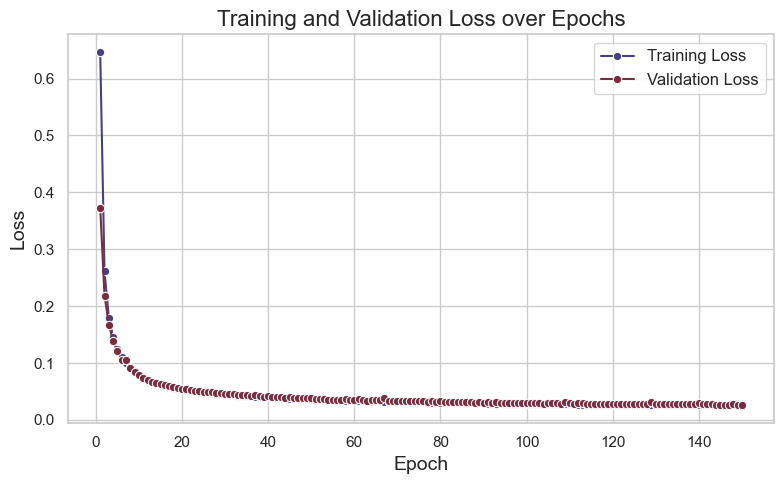

In [98]:
loss_history = json.load(open(f'models/AE_Model1_hp2_history.json'))
plot_training_loss(loss_history)

In [ ]:
# Extract latent representations of full data
model.eval()
df_clustering_scaled,_ =  feature_scaler.transform_scaler(df_clustering)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df_clustering_scaled = torch.from_numpy(df_clustering_scaled).float().to(device)

with torch.no_grad():
    latent_representations = model.encoder(df_clustering_scaled).cpu().numpy()

df_latent_representations = pd.DataFrame(latent_representations, columns=[f'latent_{i+1}' for i in range(latent_dim)])

In [99]:
df_latent_representations = pd.read_csv('models/AE_Model1_hp2_latent_space.csv')

In [100]:
max_clusters = 20
scores_ae_dict = determine_number_of_clusters_for_KMeans(df_latent_representations, max_clusters=max_clusters) 

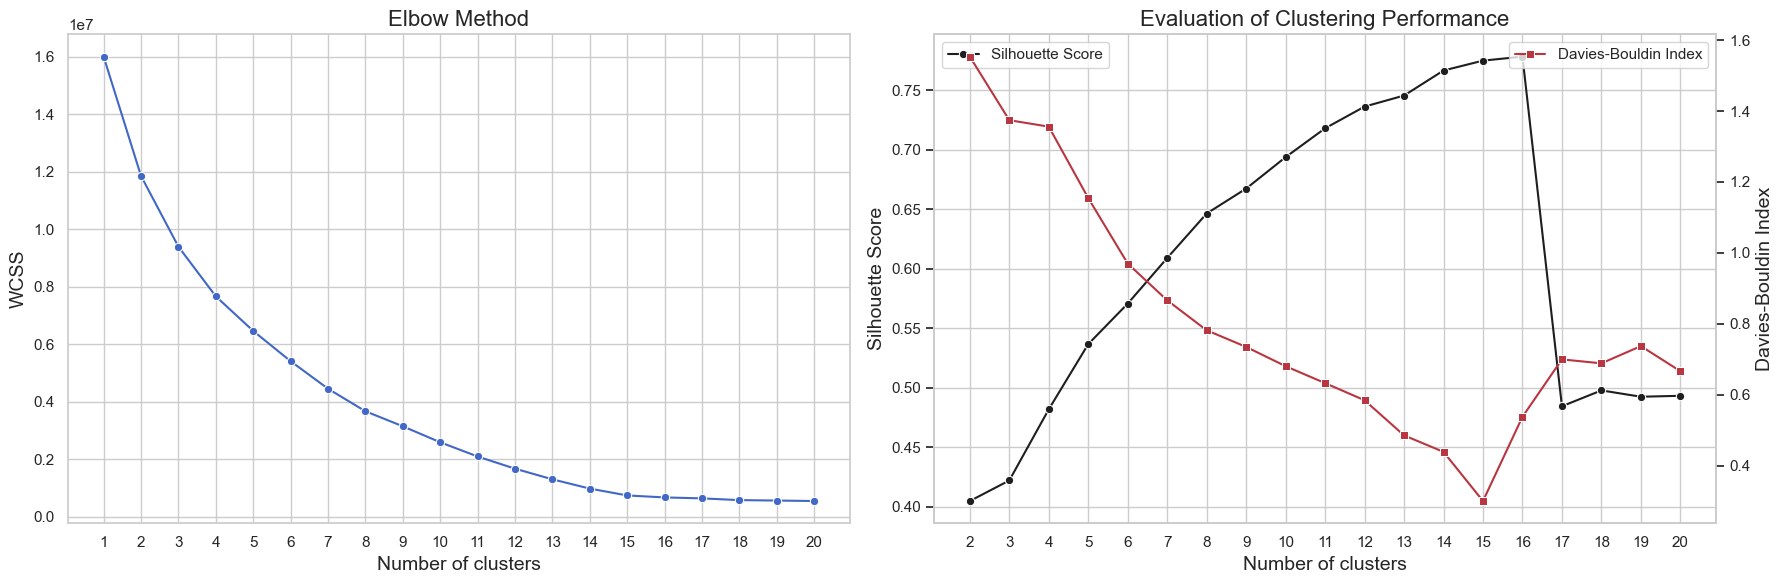

In [101]:
plot_cluster_evaluation(scores_ae_dict, max_clusters)

In [102]:
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_latent_representations['cluster'] = kmeans.fit_predict(df_latent_representations) + 1

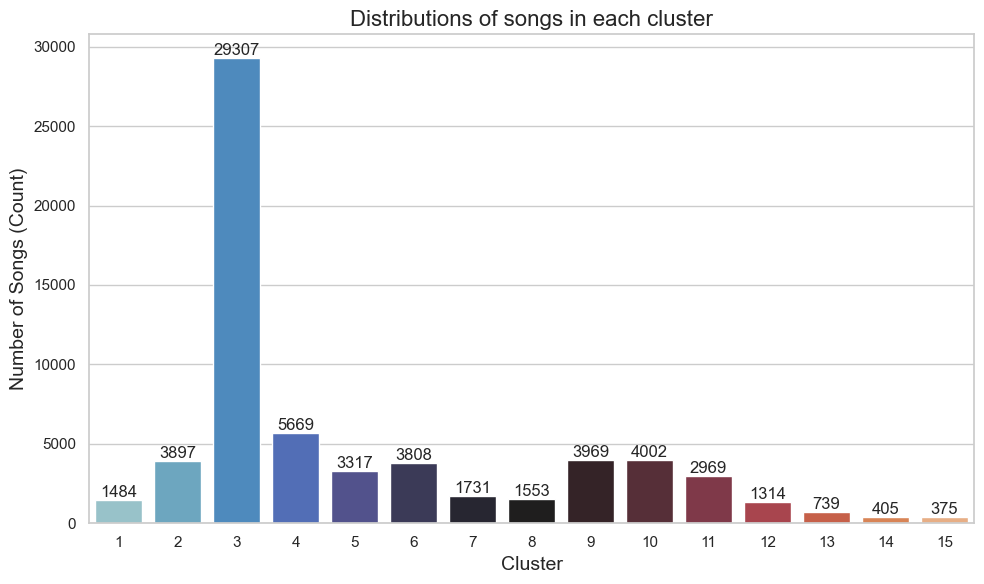

In [103]:
plot_cluster_distribution(df_latent_representations)

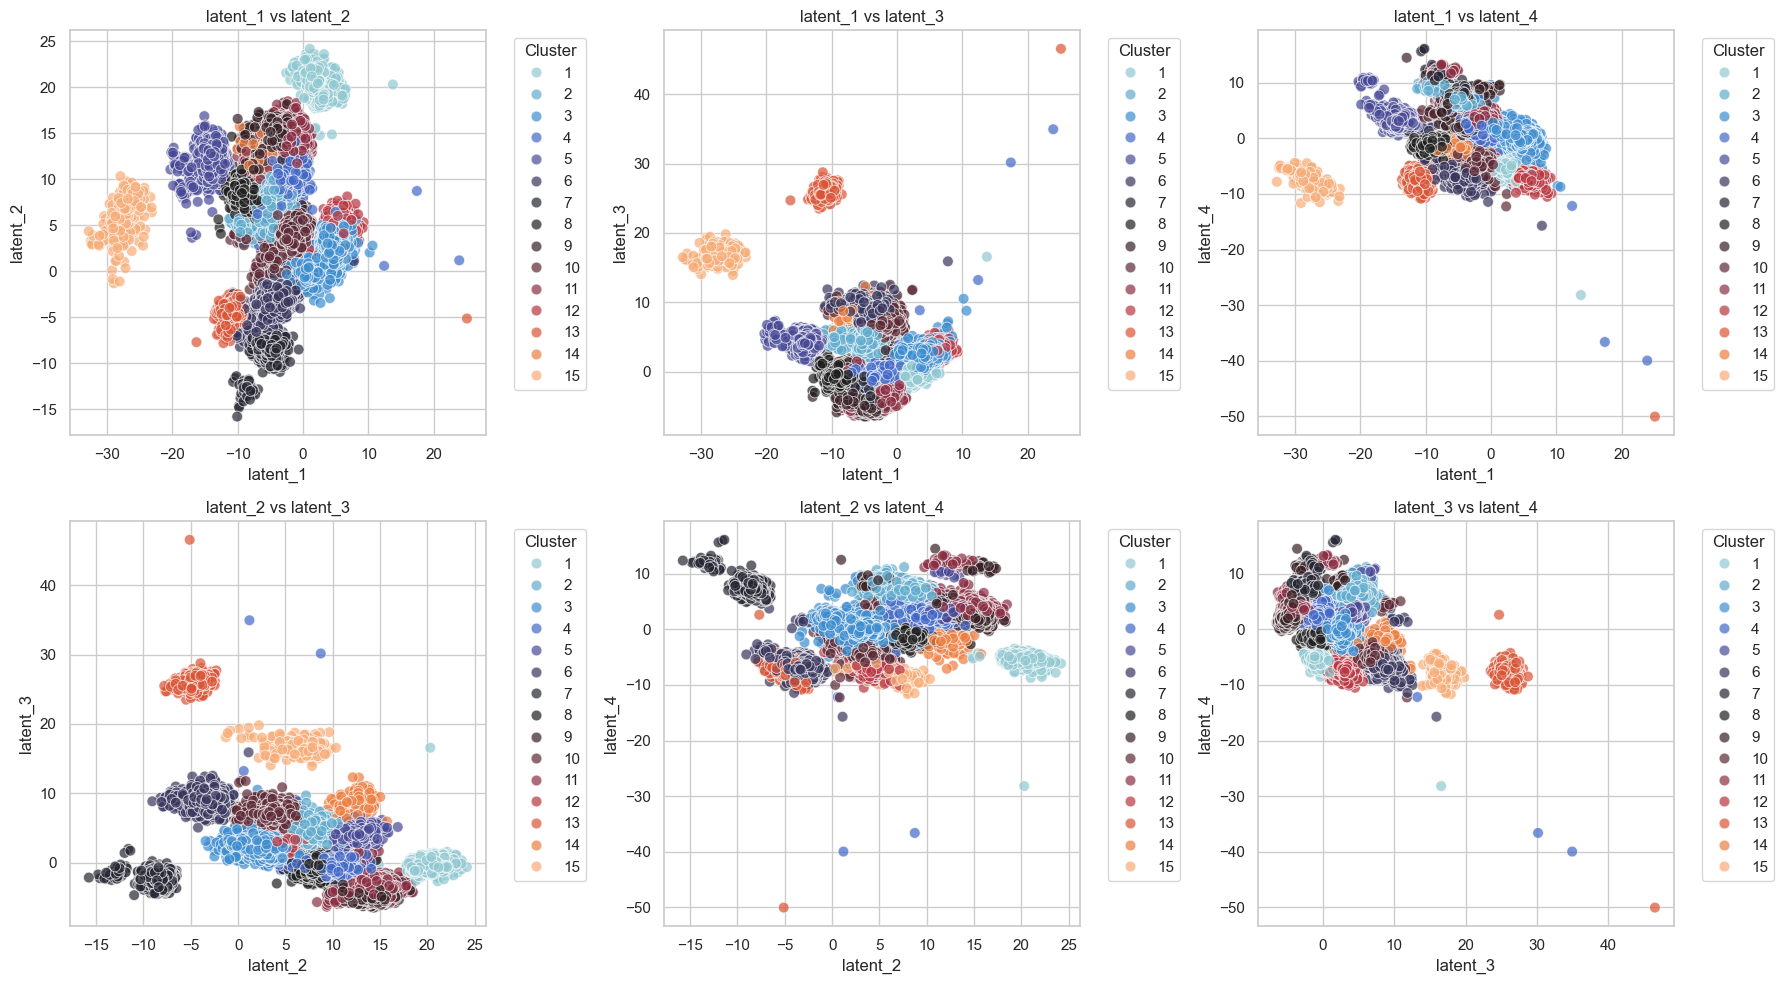

In [107]:
plot_clustering_latent(df_latent_representations, optimal_k)

In [108]:
pca_ae, pca_transformed_ae = run_pca(df_latent_representations, df_latent_representations.shape[1])
df_pca_ae = pd.DataFrame(pca_transformed_ae[:, :df_latent_representations.shape[1]], columns=[f'PC{i+1}' for i in range(df_latent_representations.shape[1])])
df_pca_ae['cluster'] = df_latent_representations['cluster']

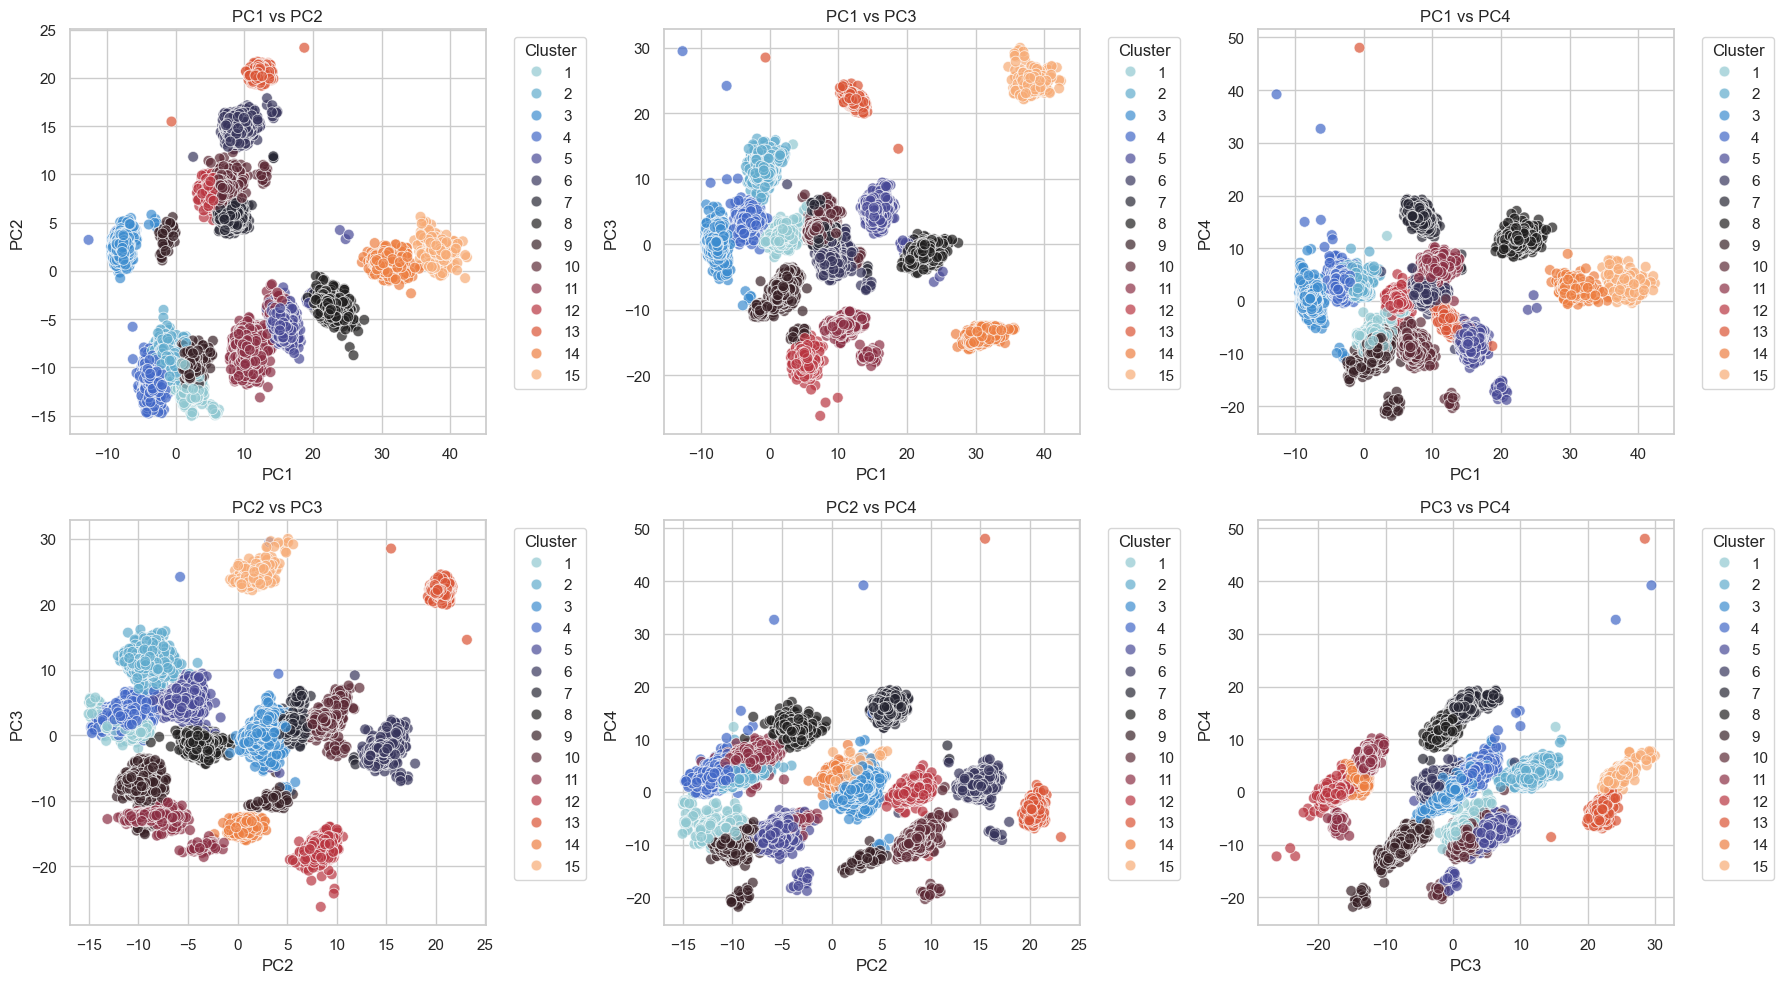

In [109]:
plot_pca_clustering(df_pca_ae, optimal_k)

- Given the three approaches, the K-Means clustering with Autoencoder outperforms the other two methods in terms of Silhouette Score and Davies-Bouldin score.
- Also, in terms of visualizing the clusters, the clusters are more separated and distinct compared to the other two methods.
- Thus, we will use the K-Means clustering with Autoencoder to cluster the songs into clusters and use these clusters to recommend songs to users.

## 4.4: Recommendation based on clustering

Using our best-performing clustering method, *Autoencoder combined with K-Means*, we will recommend songs to users based on their listening history. The recommendation process is as follows:

**Identifying Relevant Clusters:**  
- For each user in the test set, we identify the top *k* clusters associated with the songs they have listened to. For each cluster, we calculate the proportion of songs the user has already heard in that cluster relative to their total listening history. This proportion determines how many songs from each cluster should be recommended. A higher proportion indicates that the user is more likely to enjoy songs from that cluster.

**Recommending Songs:**  
- From the identified clusters, we recommend songs that the user has not previously listened to. For each user and cluster, we compute a **personalized centroid point** by taking the mean of the latent representations of the songs in the cluster that the user has listened to. This centroid represents the user’s interaction with the cluster. Songs closest to this centroid (based on distance) are prioritized, ensuring that the recommendations are most relevant to the user. The final recommendations are sorted by distance to the centroid, with the closest songs recommended first.


In [111]:
cols_clustering = ['song_id','artist_familiarity', 'artist_hotttnesss','artist_latitude','artist_longitude','artist_freq',
                    'duration', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 'song_hotttnesss', 'end_of_fade_in','start_of_fade_out','release_freq',
                    'genre_Blues','genre_Country', 'genre_Electronic', 'genre_Folk', 'genre_Jazz','genre_Latin', 'genre_Metal', 'genre_New Age', 
                    'genre_Pop','genre_Punk', 'genre_Rap', 'genre_Reggae', 'genre_RnB', 'genre_Rock','genre_World']
df_recommend = df_songs_cleaned[cols_clustering]
df_recommend['cluster'] = df_latent_representations['cluster']

In [112]:
# Load the played songs for the test users
listened_songs_ratio_split = pd.read_csv('data/processed/listened_songs_ratio_split.csv')

In [131]:
def calculate_top_k_clusters_with_ratios(listened_songs_ratio_split, df_recommend, k=3):
    """
    For each user, identify the top k clusters based on the number of songs listened to,
    and calculate the ratio of songs in each of these clusters, summing to 100%.
    
    Parameters:
    - listened_songs_ratio_split (pd.DataFrame): DataFrame with 'user_id' and 'song_id'.
    - df_clustering (pd.DataFrame): DataFrame with 'song_id' and 'cluster'.
    - k (int): Number of top clusters to identify per user.
    
    Returns:
    - pd.DataFrame: DataFrame with 'user_id' and columns for each top cluster's ID and ratio.
    """
    
    # Step 1: Merge the DataFrames on 'song_id'
    merged_df = listened_songs_ratio_split.merge(df_recommend, on='song_id', how='left')
    
    # Check for any songs that didn't merge correctly
    if merged_df['cluster'].isnull().any():
        missing_clusters = merged_df[merged_df['cluster'].isnull()]['song_id'].unique()
        print(f"Warning: The following song_ids do not have a corresponding cluster and will be excluded: {missing_clusters}")
        merged_df = merged_df.dropna(subset=['cluster'])
    
    # Step 2: Group by 'user_id' and 'cluster' and count the number of songs
    grouped = merged_df.groupby(['user_id', 'cluster']).size().reset_index(name='count')
    
    # Step 3: For each user, sort clusters by count descending and assign rank
    grouped_sorted = grouped.sort_values(['user_id', 'count'], ascending=[True, False])
    grouped_sorted['rank'] = grouped_sorted.groupby('user_id')['count'].rank(method='first', ascending=False).astype(int)
    
    # Select only top k clusters per user
    top_k = grouped_sorted[grouped_sorted['rank'] <= k]
    
    # Step 4: Calculate the total counts for top k clusters per user
    top_k['total_top_k'] = top_k.groupby('user_id')['count'].transform('sum')
    
    # Calculate the ratio for each top cluster
    top_k['ratio'] = (top_k['count'] / top_k['total_top_k']) * 100
    
    # Step 5: Pivot the DataFrame to have separate columns for each top cluster's ID and ratio
    # We'll create separate columns for cluster IDs and their corresponding ratios
    pivot_cluster = top_k.pivot(index='user_id', columns='rank', values='cluster')
    pivot_ratio = top_k.pivot(index='user_id', columns='rank', values='ratio')
    
    # Rename the columns to reflect their rank
    pivot_cluster = pivot_cluster.rename(columns=lambda x: f'cluster_top_{x}')
    pivot_ratio = pivot_ratio.rename(columns=lambda x: f'ratio_{x}')
    
    # Step 6: Combine the cluster IDs and ratios into a single DataFrame
    result_df = pivot_cluster.join(pivot_ratio).reset_index().rename_axis(None, axis=1)
    
    # Handle users with fewer than k clusters by filling NaN with appropriate values
    for i in range(1, k+1):
        cluster_col = f'cluster_top_{i}'
        ratio_col = f'ratio_{i}'
        if cluster_col not in result_df.columns:
            result_df[cluster_col] = pd.NA
        if ratio_col not in result_df.columns:
            result_df[ratio_col] = pd.NA
        
    # Optional: Sort the columns for better readability
    cols = ['user_id']
    for i in range(1, k+1):
        cols.extend([f'cluster_top_{i}', f'ratio_{i}'])
    result_df = result_df[cols]
    
    return result_df


In [133]:
# Calculate top 3 cluster ratios per user
cluster_ratio_user = calculate_top_k_clusters_with_ratios(listened_songs_ratio_split, df_recommend, k=3)

In [115]:
cluster_ratio_user.head()

,user_id,cluster_top_1,ratio_1,cluster_top_2,ratio_2,cluster_top_3,ratio_3
0,0003a64f7a69e5b87a80b09c3772227185c235c7,3.0,68.888889,12.0,22.222222,10.0,8.888889
1,00053fba2e2651242dbce9b4f73b620b4eda990a,3.0,87.500000,2.0,8.333333,9.0,4.166667
2,0009dc26c4ae94eb9409a726c26d3fe749f6faa1,3.0,75.000000,10.0,15.000000,9.0,10.000000
3,000e8ae5694b5ffd54287c53e8a0ec3cc44e9667,10.0,52.631579,3.0,31.578947,4.0,15.789474
4,000f1280e22b190d6840ba3f1524fa6872304e1b,3.0,62.500000,4.0,25.000000,5.0,12.500000


In [135]:
df_latent_representations['song_id'] = df_songs_cleaned['song_id']
df_latent_user_centroids = pd.merge(df_latent_representations, listened_songs_ratio_split, on='song_id', how='inner')
df_latent_user_centroids = df_latent_user_centroids.groupby(['user_id', 'cluster']).mean().reset_index()

In [136]:
def recommend_songs_centroid_based(cluster_ratio_user, 
                                    df_latent_user_centroids, 
                                    df_latent_representations, 
                                    k_songs, 
                                    listened_songs_ratio_split):
    """
    Recommend songs to users based on their cluster ratios and listening history using centroid-based selection.
    Includes both recommended song IDs and their corresponding distance scores.
    
    Parameters:
    - cluster_ratio_user (pd.DataFrame): DataFrame with 'user_id', 'cluster_top_1', 'ratio_1', ..., 'cluster_top_3', 'ratio_3'.
    - df_latent_user_centroids (pd.DataFrame): DataFrame with 'user_id', 'cluster', 'latent_1', ..., 'latent_10'.
    - df_latent_representations (pd.DataFrame): DataFrame with 'song_id', 'cluster', 'latent_1', ..., 'latent_10'.
    - k_songs (int): The number of songs to recommend.
    - listened_songs_ratio_split (pd.DataFrame): DataFrame with 'user_id' and 'song_id'.
    
    Returns:
    - recommendations_df (pd.DataFrame): DataFrame with 'user_id', 'recommended_songs' (list of song_ids), and 'scores' (list of distances).
    """
    recommendations = []
    
    # Define latent dimensions
    latent_dimensions = [f'latent_{i}' for i in range(1, 11)]
    
    # Create a dictionary mapping cluster_id to its songs' latent vectors and song_ids
    cluster_to_songs = {}
    for cluster_id, group in df_latent_representations.groupby('cluster'):
        song_ids = group['song_id'].tolist()
        song_vectors = group[latent_dimensions].values.astype(float)  # Ensure float type
        cluster_to_songs[cluster_id] = {'song_ids': song_ids, 'vectors': song_vectors}
    
    # Create a dictionary for user listened songs for quick lookup
    user_listened_dict = listened_songs_ratio_split.groupby('user_id')['song_id'].apply(set).to_dict()
    
    # Create a dictionary for user centroids per cluster
    user_centroids = {}
    for _, row in df_latent_user_centroids.iterrows():
        user_id = row['user_id']
        cluster_id = row['cluster']
        centroid_vector = row[latent_dimensions].values.astype(float).flatten()  # Ensure float type
        if user_id not in user_centroids:
            user_centroids[user_id] = {}
        user_centroids[user_id][cluster_id] = centroid_vector
    
    # Iterate over each user in cluster_ratio_user
    for idx, user_row in cluster_ratio_user.iterrows():
        user_id = user_row['user_id']
        # Extract top clusters and ratios
        cluster_tops = [user_row.get(f'cluster_top_{i}', np.nan) for i in range(1, 4)]
        ratios = [user_row.get(f'ratio_{i}', 0) for i in range(1, 4)]
        
        # Filter out invalid clusters and normalize ratios
        clusters_and_ratios = [(c, r) for c, r in zip(cluster_tops, ratios) if pd.notnull(c) and r > 0]
        if not clusters_and_ratios:
            continue  # Skip if no valid clusters
        cluster_tops_filtered, ratios_filtered = zip(*clusters_and_ratios)
        total_ratio = sum(ratios_filtered)
        ratios_normalized = [r / total_ratio for r in ratios_filtered]
        
        # Calculate number of songs to recommend from each cluster
        song_numbers = [int(np.floor(k_songs * r)) for r in ratios_normalized]
        
        # Adjust song_numbers to sum to k_songs
        remainder = k_songs - sum(song_numbers)
        if remainder > 0:
            remainders = [k_songs * r - sn for r, sn in zip(ratios_normalized, song_numbers)]
            for _ in range(remainder):
                idx_max_remain = np.argmax(remainders)
                song_numbers[idx_max_remain] += 1
                remainders[idx_max_remain] = 0  # Avoid selecting the same index again
        
        # Get user's listened songs
        listened_songs = user_listened_dict.get(user_id, set())
        
        user_recommendations = []
        user_scores = []
        unallocated_songs_needed = 0
        
        for cluster_id, num_songs in zip(cluster_tops_filtered, song_numbers):
            if num_songs <= 0:
                continue
            # Retrieve songs and vectors for the cluster
            songs_info = cluster_to_songs.get(cluster_id, None)
            if not songs_info:
                unallocated_songs_needed += num_songs
                continue  # No songs available in this cluster
            
            song_ids = songs_info['song_ids']
            song_vectors = songs_info['vectors']
            
            # Retrieve user's centroid for this cluster
            centroid = user_centroids.get(user_id, {}).get(cluster_id, None)
            if centroid is None:
                unallocated_songs_needed += num_songs
                continue  # No centroid available for this user in this cluster
            
            # Compute distances between centroid and all songs in the cluster using scipy's cdist
            try:
                distances = cdist(song_vectors, centroid.reshape(1, -1), metric='euclidean').flatten() # cosine
            except Exception as e:
                print(f"Error computing distances for user {user_id} in cluster {cluster_id}: {e}")
                unallocated_songs_needed += num_songs
                continue
            
            # Create a DataFrame for sorting
            df_distances = pd.DataFrame({
                'song_id': song_ids,
                'distance': distances
            })
            
            # Exclude already listened songs and already recommended songs
            df_distances = df_distances[~df_distances['song_id'].isin(listened_songs)]
            df_distances = df_distances[~df_distances['song_id'].isin(user_recommendations)]
            
            # Sort by distance (ascending)
            df_distances_sorted = df_distances.sort_values(by='distance')
            
            # Select top N songs
            top_songs_df = df_distances_sorted[['song_id', 'distance']].head(num_songs)
            top_songs = top_songs_df['song_id'].tolist()
            top_distances = top_songs_df['distance'].tolist()
            
            # Append to recommendations
            user_recommendations.extend(top_songs)
            user_scores.extend(top_distances)
            
            # If not enough songs, track the unallocated number
            actual_recommended = len(top_songs)
            if actual_recommended < num_songs:
                unallocated_songs_needed += (num_songs - actual_recommended)
        
        # Allocate any unallocated songs from other clusters
        if unallocated_songs_needed > 0:
            # Identify other clusters not in the top clusters
            top_clusters_set = set(cluster_tops_filtered)
            other_clusters = set(cluster_to_songs.keys()) - top_clusters_set
            
            # Aggregate all songs from other clusters
            other_songs = []
            for cluster_id in other_clusters:
                songs_info = cluster_to_songs.get(cluster_id, {})
                if not songs_info:
                    continue
                other_songs.extend(songs_info['song_ids'])
            
            # Exclude listened songs and already recommended songs
            remaining_songs = list(set(other_songs) - listened_songs - set(user_recommendations))
            if remaining_songs:
                # For simplicity, randomly select from remaining_songs
                try:
                    num_extra = min(unallocated_songs_needed, len(remaining_songs))
                    extra_songs = np.random.choice(remaining_songs, size=num_extra, replace=False)
                    user_recommendations.extend(extra_songs)
                    # Assign a default score for these extra songs, e.g., None
                    user_scores.extend([None]*num_extra)
                except Exception as e:
                    print(f"Error allocating extra songs for user {user_id}: {e}")
        
        # Ensure the total number of recommendations is k_songs
        user_recommendations = user_recommendations[:k_songs]
        user_scores = user_scores[:k_songs]
        
        # Append to the recommendations list
        recommendations.append({
            'user_id': user_id,
            'recommended_songs': user_recommendations,
            'scores': user_scores
        })
    
    # Create the final recommendations DataFrame
    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df



In [ ]:
# Parameters
k_songs = 50  # Number of songs to recommend per user
recommendations_df = recommend_songs_centroid_based(
    cluster_ratio_user=cluster_ratio_user,
    df_latent_user_centroids=df_latent_user_centroids,
    df_latent_representations=df_latent_representations,
    k_songs=k_songs,
    listened_songs_ratio_split=listened_songs_ratio_split
)

In [139]:
recommendations_df.head()

,user_id,recommended_songs,scores
0,0003a64f7a69e5b87a80b09c3772227185c235c7,"[SOQJOCS12A8C132AC4, SOVKCHX12A58A79989, SOIRG...","[0.7649590874683829, 0.8156234771762797, 0.832..."
1,00053fba2e2651242dbce9b4f73b620b4eda990a,"[SOBKPCM12AF729D82E, SOVBROC12A8C13D0FE, SOJDF...","[0.5470794176667461, 0.7361819081723503, 0.745..."
2,0009dc26c4ae94eb9409a726c26d3fe749f6faa1,"[SOOPDPQ12A5891DCC5, SOMZRWW12A6D4FB461, SOEKU...","[0.691572280421321, 0.7180559561742073, 0.7393..."
3,000e8ae5694b5ffd54287c53e8a0ec3cc44e9667,"[SOXDEGI12A8C13176B, SOVQAEN12A8C135EEC, SODJZ...","[0.8599604890838144, 0.8812351028733342, 0.896..."
4,000f1280e22b190d6840ba3f1524fa6872304e1b,"[SONXDTN12AB018BC6B, SOOLQAH12A8C13181F, SOQEY...","[0.6872505009361327, 0.7193432624024745, 0.733..."


## 4.4: Evaluation of recommendations based on clustering

In [140]:
def evaluate_recommendations(recommendations_df, masked_songs_df, k):
    """
    Evaluate the recommendations using Precision@k and Recall@k.
    
    Parameters:
    - recommendations_df (pd.DataFrame): DataFrame with 'user_id' and 'recommended_songs' (list of song_ids).
    - masked_songs_df (pd.DataFrame): DataFrame with 'user_id' and 'song_id' of masked songs.
    - k (int): The number of top recommendations to consider.
    
    Returns:
    - evaluation_df (pd.DataFrame): DataFrame with 'user_id', 'precision_at_k', 'recall_at_k'.
    """
    # Ensure the recommended_songs are lists
    recommendations_df['recommended_songs'] = recommendations_df['recommended_songs'].apply(list)
    
    # Group masked songs by user
    masked_songs_grouped = masked_songs_df.groupby('user_id')['song_id'].apply(set).reset_index()
    masked_songs_dict = dict(zip(masked_songs_grouped['user_id'], masked_songs_grouped['song_id']))
    
    evaluation_results = []
    
    for _, row in recommendations_df.iterrows():
        user_id = row['user_id']
        recommended_songs = row['recommended_songs'][:k]  # Consider only top-k recommendations
        
        # Get the masked songs for the user
        masked_songs = masked_songs_dict.get(user_id, set())
        
        if not masked_songs:
            # If there are no masked songs for the user, we cannot compute recall
            recall_at_k = None
        else:
            # Compute the number of relevant recommended songs
            relevant_recommendations = set(recommended_songs) & masked_songs
            num_relevant = len(relevant_recommendations)
            
            # Precision@k
            precision_at_k = num_relevant / k if k > 0 else 0
            # Recall@k
            recall_at_k = num_relevant / len(masked_songs) if len(masked_songs) > 0 else 0

            evaluation_results.append({
                'user_id': user_id,
                'precision_at_k': precision_at_k,
                'recall_at_k': recall_at_k
            })
    
    evaluation_df = pd.DataFrame(evaluation_results)
    return evaluation_df

In [141]:
def evaluate_cluster_coverage(cluster_ratio_user, df_recommend, masked_songs_df):
    """
    Evaluate how many of the masked songs are in the users' cluster preferences.
    
    Parameters:
    - cluster_ratio_user (pd.DataFrame): DataFrame with 'user_id', 'cluster_top_1', 'ratio_1', 'cluster_top_2', 'ratio_2', 'cluster_top_3', 'ratio_3'.
    - df_recommend (pd.DataFrame): DataFrame with 'song_id' and 'cluster'.
    - masked_songs_df (pd.DataFrame): DataFrame with 'user_id' and 'song_id' of masked songs.
    
    Returns:
    - coverage_df (pd.DataFrame): DataFrame with 'user_id' and 'proportion_in_top_clusters'.
    """
    # Map song_id to cluster
    song_cluster_dict = df_recommend.set_index('song_id')['cluster'].to_dict()
    
    # Group masked songs by user
    masked_songs_grouped = masked_songs_df.groupby('user_id')['song_id'].apply(list).reset_index()
    masked_songs_dict = dict(zip(masked_songs_grouped['user_id'], masked_songs_grouped['song_id']))
    
    coverage_results = []
    
    for _, user_row in cluster_ratio_user.iterrows():
        user_id = user_row['user_id']
        cluster_tops = [
            int(user_row['cluster_top_1']) if pd.notnull(user_row['cluster_top_1']) else None,
            int(user_row['cluster_top_2']) if pd.notnull(user_row['cluster_top_2']) else None,
            int(user_row['cluster_top_3']) if pd.notnull(user_row['cluster_top_3']) else None
        ]
        # Filter out None values
        cluster_tops = [c for c in cluster_tops if c is not None]
        
        # Get the user's masked songs
        user_masked_songs = masked_songs_dict.get(user_id, [])
        if not user_masked_songs:
            continue  # Skip users with no masked songs
        
        # Map masked songs to clusters
        masked_song_clusters = [song_cluster_dict.get(song_id) for song_id in user_masked_songs]
        
        # Count how many masked songs are in user's top clusters
        count_in_top_clusters = sum(1 for cluster in masked_song_clusters if cluster in cluster_tops)
        total_masked_songs = len(user_masked_songs)
        
        # Calculate proportion
        proportion_in_top_clusters = count_in_top_clusters / total_masked_songs if total_masked_songs > 0 else 0
        
        coverage_results.append({
            'user_id': user_id,
            'proportion_in_top_clusters': proportion_in_top_clusters,
            'total_masked_songs': total_masked_songs,
            'count_in_top_clusters': count_in_top_clusters
        })
    
    coverage_df = pd.DataFrame(coverage_results)
    return coverage_df

In [142]:
masked_songs_ratio_split = data_loader.load_csv_file(data_path='data/processed/masked_songs_ratio_split.csv')

In [143]:
k=50
evaluation_df = evaluate_recommendations(recommendations_df, masked_songs_ratio_split, k=k)
mean_precision_at_k = evaluation_df['precision_at_k'].mean()
mean_recall_at_k = evaluation_df['recall_at_k'].dropna().mean() 
print(f"Mean Precision@{k}: {mean_precision_at_k:.4f}")
print(f"Mean Recall@{k}: {mean_recall_at_k:.4f}")

Mean Precision@50: 0.0069
Mean Recall@50: 0.0441


In [144]:
coverage_df = evaluate_cluster_coverage(cluster_ratio_user, df_recommend, masked_songs_ratio_split)
mean_proportion = coverage_df['proportion_in_top_clusters'].mean()
print(f"Mean Proportion of Masked Songs in Top Clusters: {mean_proportion:.4f}")


Mean Proportion of Masked Songs in Top Clusters: 0.8523


# 5. Collaborative Filtering

# 6. Apriori Algorithm

# 7. Ensemble-Based Song Recommender System

In [ ]:
# vægt efter performance og confidence

lav ensemble clusters - returnere

tre dataframe for hver metode med users og 50 x 3 sange 

1. regel tag der forekommer flest gange på tværs af metoderne
2. 

returnere for hver user en prioriteret liste af 10 sange

